### Numerical simulation of the anaerobic cell growth of *Saccharomyces cerevisiae*

Objective: To solve a system of four differential equations regarding the anaerobic cell growth of *Saccharomyces cerevisiae* coupled to extracellular ethanol production

Source: Andrade, R. R., Filho, F. M., Filho, R. M., Costa, A. C. __*Kinetics of ethanol production from sugarcane bagasse enzymatic hydrolysate concentrated with molasses under cell recycle*__, 2013.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

### 1. Kinetic parameters as functions of temperature

### 1.1. $\mu_{max}$ - Specific growth rate ($h^{-1}$)

In [2]:
def CalculaUmax(T):
    #A = -2.886e5
    #B = -194.839
    #C = 2.884e5
    #D = -194.802
    #umax = A*np.exp(B/T) + C*np.exp(D/T)
    umax = -0.00266071*T**2 + 0.18037857*T - 2.86700000

    return umax

### 1.2. $X_{max}$ - Maximum cell concentration (kg/m³)

In [3]:
def CalculaXmax(T):
    #A = 0.553
    #B = 145.900
    #C = 1.68e6
    #D = -43700
    #Xmax = A*np.exp(B/T) + C*np.exp(D/T)
    Xmax = 0.76071429*T**2 - 55.69857143*T + 1058.18000000
    
    return Xmax

### 1.3. $P_{max}$ - Maximum product concentration (kg/m³)

In [4]:
def CalculaPmax(T):
    #A = 9.727e-3
    #B = 252.700
    #C = 147.600
    #D = -31.470
    #Pmax = A*np.exp(B/T) + C*np.exp(D/T)
    Pmax = 0.57678571*T**2 - 42.06642857*T + 838.23200000
    
    return Pmax    

### 1.4. $Y_{PX}$ - Product to biomass yield (kg/kg)

In [5]:
def CalculaYpx(T):
    #A = -2.795e5
    #B = -92.567
    #C = 2.794e5
    #D = -92.526
    #Ypx = A*np.exp(B/T) + C*np.exp(D/T)
    Ypx = -0.02071429*T**2 + 1.90357143*T - 26.44400000
    
    return Ypx

### 1.5. $Y_{X}$ - Biomass to substrate yield

In [6]:
def CalculaYx(T):
    #A = -2.797e5
    #B = -87.618
    #C = 2.797e5
    #D = -87.618
    #Yx = A*np.exp(B/T) + C*np.exp(D/T)
    Yx = -0.00016071*T**2 + 0.00917857*T - 0.09160000

    return Yx

(0.0, 1.0, 0.0, 1.0)

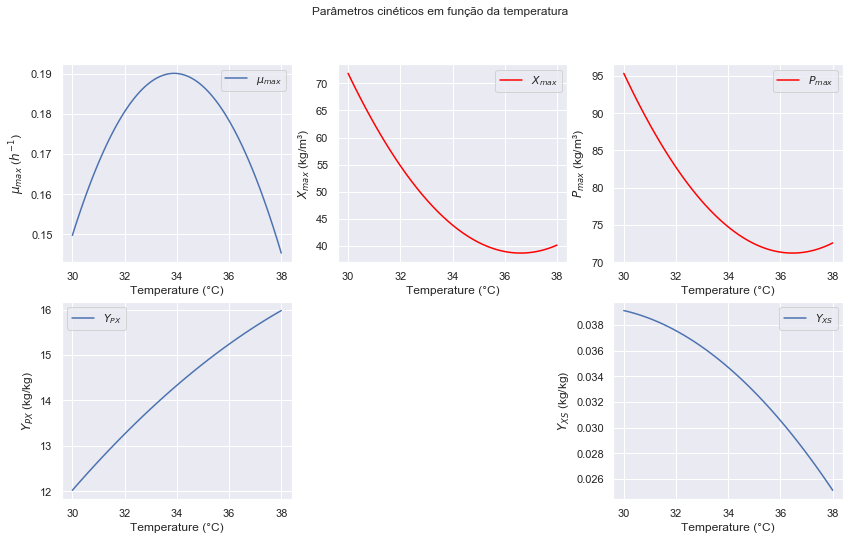

In [7]:
fig, axs = plt.subplots(2,3,figsize=(14,8))
plt.suptitle("Parâmetros cinéticos em função da temperatura")

Temp = np.linspace(30,38, 100)

umax = CalculaUmax(Temp)
axs[0,0].plot(Temp,umax,label="$\mu_{max}$")
#axs[0,0].set_title("$\mu_{max}$")
axs[0,0].set_xlabel("Temperature (°C)")
axs[0,0].set_ylabel("$\mu_{max}$ ($h^{-1}$)")
axs[0,0].legend()

xmax = CalculaXmax(Temp)
axs[0,1].plot(Temp,xmax,label="$X_{max}$",color="red")
#axs[0,1].set_title("$X_{max}$")
axs[0,1].set_xlabel("Temperature (°C)")
axs[0,1].set_ylabel("$X_{max}$ (kg/m³)")
axs[0,1].legend()

pmax = CalculaPmax(Temp)
axs[0,2].plot(Temp,pmax,label="$P_{max}$",color="red")
#axs[0,2].set_title("$P_{max}$")
axs[0,2].set_xlabel("Temperature (°C)")
axs[0,2].set_ylabel("$P_{max}$ (kg/m³)")
axs[0,2].legend()

ypx = CalculaYpx(Temp)
axs[1,0].plot(Temp,ypx,label="$Y_{PX}$")
#axs[1,0].set_title("$Y_{PX}$")
axs[1,0].set_xlabel("Temperature (°C)")
axs[1,0].set_ylabel("$Y_{PX}$ (kg/kg)")
axs[1,0].legend()

yx = CalculaYx(Temp)
axs[1,2].plot(Temp,yx,label="$Y_{XS}$")
#axs[1,2].set_title("$Y_{X}$")
axs[1,2].set_xlabel("Temperature (°C)")
axs[1,2].set_ylabel("$Y_{XS}$ (kg/kg)")
axs[1,2].legend()

axs[1,1].axis('off')

### 2. Thermophysical properties of the fermentation medium

In [8]:
h_rxn = -511       # calor de reação, kJ/kg glicose
Cp = 3.82          # capacidade calorífica do mosto, kJ/kg K
d = 1060           # massa específica do mosto, kg/m³
V = 59.66          # volume reacional, m³
Frec = 31          # vazão de reciclo, m³/h           
Tsp = 30           # set-point de temperatura da malha de controle, °C
Tsp_hold = Tsp
Frec_hold = Frec

tau = V/Frec       # tempo de residência do mosto, h

### 3. Set-up of the system of differential equations that model cell growth behavior
The effect of temperature variation on the kinetic parameters is accounted for by repeatedly calling (recalculating) their respective functions at each integration step.

System of differential equations:

Biomass balance:   $\frac{dX}{dt} = X\frac{\mu_{max}S}{K_s+S}e^{-K_iS}(1-\frac{X}{X_{max}})^{m}(1-\frac{P}{P_{max}})^{n}$




Substrate balance: $\frac{dS}{dt} = -(\frac{1}{Y_{XS}}\frac{dX}{dt}+m_xX)$




Product balance:   $\frac{dP}{dt} = Y_{PX}\frac{dX}{dt}+m_pX$

Enthalpy balance:   

$\frac{dT}{dt} = \frac{{\Delta}H_{rxn}}{{\rho}Cp}\frac{dS}{dt}$  if  $T<T_{sp}$  


$\frac{dT}{dt} = \frac{{\Delta}H_{rxn}}{{\rho}Cp}\frac{dS}{dt}-\frac{F_{rec}}{V_{R}}(T-T_{sp})$$\,\,\mbox{if}\,\,\,T \geq T_{sp}$

In [9]:
# 1. construção da função que descreve o sistema de equações diferenciais - malha fechada de controle de temperatura

def cinetica_mf(e,t,Tsp,Frec): # 'e' é o vetor que contém as variáveis de estado (X, S, P e T)

    # declarando as variáveis de estado 
    X = e[0]
    S = e[1]
    P = e[2]
    T = e[3]

    # declarando as constantes do modelo
    umax = CalculaUmax(T)   # h-1
    Ks = 4.1                # kg/m³
    Ki = 0.004              # m³/kg
    Xmax = CalculaXmax(T)   # kg/m³
    Pmax = CalculaPmax(T)   # kg/m³
    m = 1.0
    n = 1.5

    Ypx = CalculaYpx(T)    # kg/kg
    Yx = CalculaYx(T)      # kg/kg
    mx = 0.2
    mp = 0.1
    
    tau = V/Frec       # tempo de residência, h

    # declarando o sistema de equações diferenciais
    dXdt = umax*(S/(Ks+S))*np.exp(-Ki*S)*((1-(X/Xmax))**m)*((1-(P/Pmax))**n)*X
    dSdt = -((dXdt/Yx)+mx*X)
    dPdt = Ypx*dXdt + mp*X
    
    if T < Tsp:                     
        dTdt = (h_rxn/(d*Cp))*dSdt   # se T está abaixo do set-point, não ocorre resfriamento (válvula de água fecha)
    elif T >= Tsp:
        dTdt = (h_rxn/(d*Cp))*dSdt - (Frec/V)*(T - Tsp)   # se T é maior ou igual ao set-point, ocorre resfriamento (válvula de água abre)

    params = [umax,Xmax,Pmax,Ypx,Yx]
    #print(params)

    return [dXdt,dSdt,dPdt,dTdt]

In [10]:
def cinetica_ma(e,t,Tsp,Frec): # 'e' é o vetor que contém as variáveis de estado (X, S, P e T)

    # declarando as variáveis de estado 
    X = e[0]
    S = e[1]
    P = e[2]
    T = e[3]

    # declarando as constantes do modelo
    umax = CalculaUmax(T)   # h-1
    Ks = 4.1                # kg/m³
    Ki = 0.004              # m³/kg
    Xmax = CalculaXmax(T)   # kg/m³
    Pmax = CalculaPmax(T)   # kg/m³
    m = 1.0
    n = 1.5

    Ypx = CalculaYpx(T)    # kg/kg
    Yx = CalculaYx(T)      # kg/kg
    mx = 0.2
    mp = 0.1
    
    tau = V/Frec       # tempo de residência, h

    # declarando o sistema de equações diferenciais
    dXdt = umax*(S/(Ks+S))*np.exp(-Ki*S)*((1-(X/Xmax))**m)*((1-(P/Pmax))**n)*X
    dSdt = -((dXdt/Yx)+mx*X)
    dPdt = Ypx*dXdt + mp*X                
    dTdt = (h_rxn/(d*Cp))*dSdt   # se T está abaixo do set-point, não ocorre resfriamento (válvula de água fecha)
    
    params = [umax,Xmax,Pmax,Ypx,Yx]
    #print(params)

    return [dXdt,dSdt,dPdt,dTdt]

### 4. Initial conditions and numerical integration with *odeint*
Integration is done at increments of time in a for loop, allowing for recalculation of temperature-dependent parameters at each integration step.

In [11]:
# 2. condições iniciais - malha fechada
X0 = 2.75    # kg/m³
S0 = 150     # kg/m³
P0 = 0      # kg/m³
T0 = 30      # kg/m³
ChuteInicial = [X0,S0,P0,T0]

# 3. declarando o domínio de tempo da simulação: 33 h, divididos em 1000 pontos
n = 1000
t = np.linspace(0,33,n)
X = np.empty_like(t)
S = np.empty_like(t)
P = np.empty_like(t)
T = np.empty_like(t)

X[0] = X0
S[0] = S0
P[0] = P0
T[0] = T0

# 4. resolução do sistema de equações diferenciais

for i in range(1,n):
    
    dt = [t[i-1],t[i]]
    
    Result = odeint(cinetica_mf,ChuteInicial,dt,args=(Tsp_hold,Frec_hold))

    # Armazenar o resultado da integração no intervalo dt
    X[i] = Result[1][0]
    S[i] = Result[1][1]
    P[i] = Result[1][2]
    T[i] = Result[1][3]

    # Recalcular o chute inicial para o próximo intervalo dt
    ChuteInicial = [X[i],S[i],P[i],T[i]]

# 5. coletando os resultados da simulação em vetores próprios e salvando em uma planilha excel
planilha = pd.DataFrame(
        {
            "X": X,
            "S": S,
            "P": P,
            "T": T,
        }
        )

#planilha.to_excel("cinetica_be_malhafechada.xlsx")

In [12]:
# 2. condições iniciais - malha aberta
X0 = 2.75    # kg/m³
S0 = 150     # kg/m³
P0 = 0      # kg/m³
T0 = 30      # kg/m³
ChuteInicial = [X0,S0,P0,T0]

# 3. declarando o domínio de tempo da simulação: 33 h, divididos em 1000 pontos
n = 1000
t_ma = np.linspace(0,33,n)
X_ma = np.empty_like(t)
S_ma = np.empty_like(t)
P_ma = np.empty_like(t)
T_ma = np.empty_like(t)

X_ma[0] = X0
S_ma[0] = S0
P_ma[0] = P0
T_ma[0] = T0

# 4. resolução do sistema de equações diferenciais

for i in range(1,n):
    
    dt = [t_ma[i-1],t_ma[i]]
    
    Result = odeint(cinetica_ma,ChuteInicial,dt,args=(Tsp_hold,Frec_hold))

    # Armazenar o resultado da integração no intervalo dt
    X_ma[i] = Result[1][0]
    S_ma[i] = Result[1][1]
    P_ma[i] = Result[1][2]
    T_ma[i] = Result[1][3]

    # Recalcular o chute inicial para o próximo intervalo dt
    ChuteInicial = [X_ma[i],S_ma[i],P_ma[i],T_ma[i]]

# 5. coletando os resultados da simulação em vetores próprios e salvando em uma planilha excel
planilha = pd.DataFrame(
        {
            "X": X,
            "S": S,
            "P": P,
            "T": T,
        }
        )

#planilha.to_excel("cinetica_be_malhaaberta.xlsx")

### 5. Graphical visualization of the simulation results

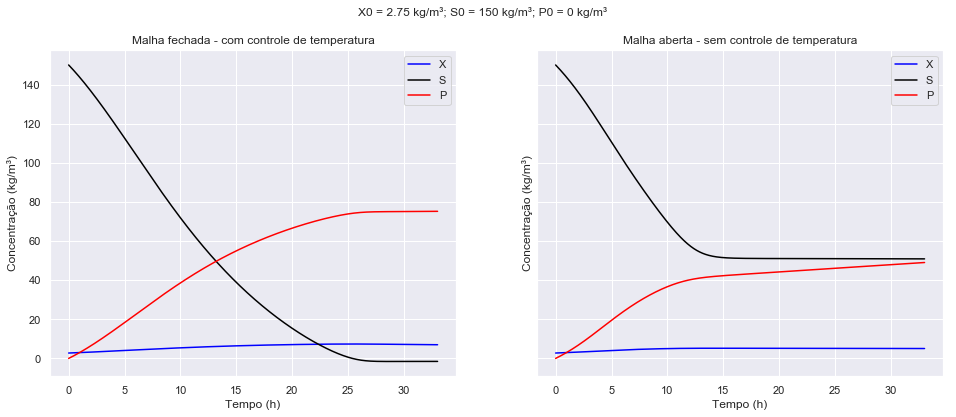

In [13]:
# 6. visualizando os resultados graficamente

fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
plt.suptitle("X0 = "+str(X0)+" kg/m³; "+"S0 = "+str(S0)+" kg/m³; "+"P0 = "+str(P0)+" kg/m³")

ax[0].plot(t,X,label="X",color="blue")
ax[0].plot(t,S,label="S", color="black")
ax[0].plot(t,P,label="P", color="red")
ax[0].set_xlabel("Tempo (h)")
ax[0].set_ylabel("Concentração (kg/m³)")
ax[0].set_title("Malha fechada - com controle de temperatura")
ax[0].legend()

ax[1].plot(t,X_ma,label="X",color="blue")
ax[1].plot(t,S_ma,label="S", color="black")
ax[1].plot(t,P_ma,label="P", color="red")
ax[1].set_xlabel("Tempo (h)")
ax[1].set_ylabel("Concentração (kg/m³)")
ax[1].set_title("Malha aberta - sem controle de temperatura")
ax[1].legend()

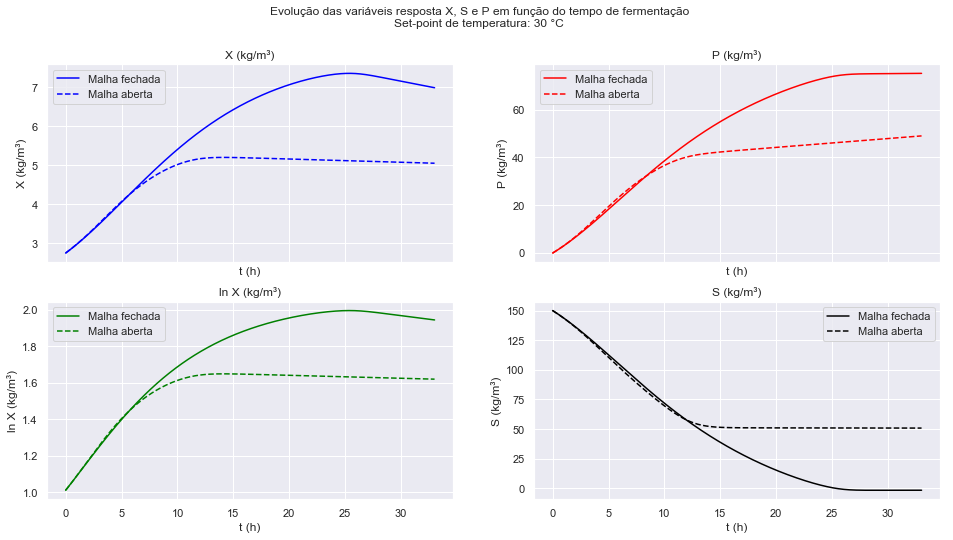

In [14]:
# 7. visualizando a curva de crescimento celular
fig, eixo = plt.subplots(2,2, sharex=True, figsize=(16,8))
plt.suptitle("Evolução das variáveis resposta X, S e P em função do tempo de fermentação\nSet-point de temperatura: "+str(Tsp)+" °C")

eixo[0,0].plot(t,X,label="Malha fechada",color="blue")
eixo[0,0].plot(t,X_ma,label="Malha aberta",color="blue",linestyle='--')
eixo[0,0].set_title("X (kg/m³)")
eixo[0,0].set_ylabel("X (kg/m³)")
eixo[0,0].set_xlabel("t (h)")
eixo[0,0].legend()

eixo[0,1].plot(t,P,color="red",label="Malha fechada")
eixo[0,1].plot(t,P_ma,color="red",label="Malha aberta",linestyle='--')
eixo[0,1].set_title("P (kg/m³)")
eixo[0,1].set_ylabel("P (kg/m³)")
eixo[0,1].set_xlabel("t (h)")
eixo[0,1].legend()

eixo[1,0].plot(t,np.log(X),label="Malha fechada",color="green")
eixo[1,0].plot(t,np.log(X_ma),label="Malha aberta",linestyle='--',color="green")
eixo[1,0].set_title("ln X (kg/m³)")
eixo[1,0].set_ylabel("ln X (kg/m³)")
eixo[1,0].set_xlabel("t (h)")
eixo[1,0].legend()

eixo[1,1].plot(t,S,color="black",label="Malha fechada")
eixo[1,1].plot(t,S_ma,color="black",label="Malha aberta",linestyle='--')
eixo[1,1].set_title("S (kg/m³)")
eixo[1,1].set_ylabel("S (kg/m³)")
eixo[1,1].set_xlabel("t (h)")
eixo[1,1].legend()

Text(0.5, 1.0, 'Tempo de residência: 1.92 h; Set-point de temperatura: 30 °C')

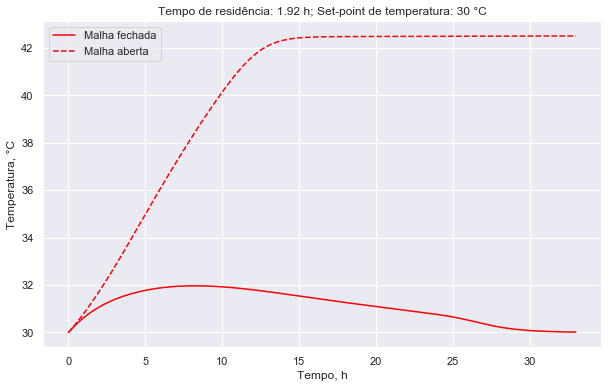

In [15]:
# 8. visualizando o perfil de temperatura desenvolvido
plt.figure(figsize=(10,6))
plt.plot(t,T,label="Malha fechada",color="red")
plt.plot(t,T_ma,label="Malha aberta",color="red",linestyle='--')
plt.legend()
plt.xlabel("Tempo, h")
plt.ylabel("Temperatura, °C")
plt.title("Tempo de residência: "+str(round(tau,2))+" h; "+"Set-point de temperatura: "+str(Tsp)+" °C")

### Sensitivity analysis: initial temperature (T0)

In [16]:
# 2. condições iniciais
X0 = 2.75                  # kg/m³
S0 = 150                   # kg/m³
P0 = 0                     # kg/m³
T0 = [30,32,34,36,38]      # °C
ChuteInicial = [X0,S0,P0,T0]

# 3. declarando o domínio de tempo da simulação: 33 h, divididos em 1000 pontos
n = 1000
t = np.linspace(0,33,n)

# criação do "tensor" que armazenará os resultados das simulações para cada temperatura
Results = np.zeros((len(T0),4,n)) # 5 rodadas de simulação diferentes, cada uma com 4 variáveis-resposta (X,S,P,T) e 1000 pontos (n)

# 4. resolução do sistema de equações diferenciais
for j in range(0,len(T0)):
    
    X_batch = np.empty_like(t)
    S_batch = np.empty_like(t)
    P_batch = np.empty_like(t)
    T_batch = np.empty_like(t)

    X_batch[0] = X0
    S_batch[0] = S0
    P_batch[0] = P0
    T_batch[0] = T0[j]
    
    ChuteInicial = [X0,S0,P0,T0[j]]
    
    for i in range(1,n):
    
        dt = [t[i-1],t[i]]
    
        Solution = odeint(cinetica_mf,ChuteInicial,dt,args=(Tsp_hold,Frec_hold))

        # Armazenar o resultado da integração no intervalo dt
        X_batch[i] = Solution[1][0]
        S_batch[i] = Solution[1][1]
        P_batch[i] = Solution[1][2]
        T_batch[i] = Solution[1][3]

        # Recalcular o chute inicial para o próximo intervalo dt
        ChuteInicial = [X_batch[i],S_batch[i],P_batch[i],T_batch[i]]
    
    # Armazenar os resultados da batelada de simulação
    Results[j] = np.array([X_batch,S_batch,P_batch,T_batch])


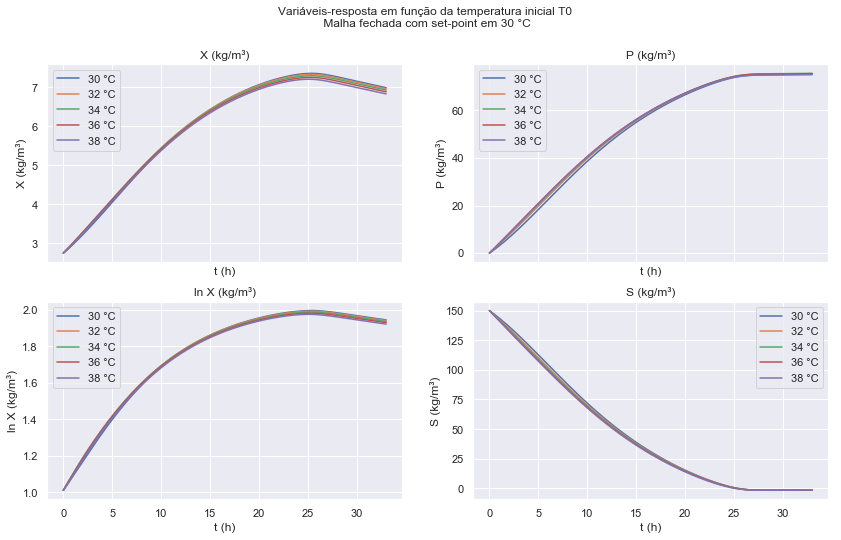

In [17]:
fig, axs = plt.subplots(2,2,sharex=True,figsize=(14,8))
plt.suptitle("Variáveis-resposta em função da temperatura inicial T0\n Malha fechada com set-point em "+str(Tsp)+" °C")

x_30 = Results[0][0][:]
x_32 = Results[1][0][:]
x_34 = Results[2][0][:]
x_36 = Results[3][0][:]
x_38 = Results[4][0][:]

s_30 = Results[0][1][:]
s_32 = Results[1][1][:]
s_34 = Results[2][1][:]
s_36 = Results[3][1][:]
s_38 = Results[4][1][:]

p_30 = Results[0][2][:]
p_32 = Results[1][2][:]
p_34 = Results[2][2][:]
p_36 = Results[3][2][:]
p_38 = Results[4][2][:]

axs[0,0].plot(t,x_30,label="30 °C")
axs[0,0].plot(t,x_32,label="32 °C")
axs[0,0].plot(t,x_34,label="34 °C")
axs[0,0].plot(t,x_36,label="36 °C")
axs[0,0].plot(t,x_38,label="38 °C")
axs[0,0].set_title("X (kg/m³)")
axs[0,0].set_ylabel("X (kg/m³)")
axs[0,0].set_xlabel("t (h)")
axs[0,0].legend()

axs[0,1].plot(t,p_30,label="30 °C")
axs[0,1].plot(t,p_32,label="32 °C")
axs[0,1].plot(t,p_34,label="34 °C")
axs[0,1].plot(t,p_36,label="36 °C")
axs[0,1].plot(t,p_38,label="38 °C")
axs[0,1].set_title("P (kg/m³)")
axs[0,1].set_ylabel("P (kg/m³)")
axs[0,1].set_xlabel("t (h)")
axs[0,1].legend()

axs[1,0].plot(t,np.log(x_30),label="30 °C")
axs[1,0].plot(t,np.log(x_32),label="32 °C")
axs[1,0].plot(t,np.log(x_34),label="34 °C")
axs[1,0].plot(t,np.log(x_36),label="36 °C")
axs[1,0].plot(t,np.log(x_38),label="38 °C")
axs[1,0].set_title("ln X (kg/m³)")
axs[1,0].set_ylabel("ln X (kg/m³)")
axs[1,0].set_xlabel("t (h)")
axs[1,0].legend()

axs[1,1].plot(t,s_30,label="30 °C")
axs[1,1].plot(t,s_32,label="32 °C")
axs[1,1].plot(t,s_34,label="34 °C")
axs[1,1].plot(t,s_36,label="36 °C")
axs[1,1].plot(t,s_38,label="38 °C")
axs[1,1].set_title("S (kg/m³)")
axs[1,1].set_ylabel("S (kg/m³)")
axs[1,1].set_xlabel("t (h)")
axs[1,1].legend()

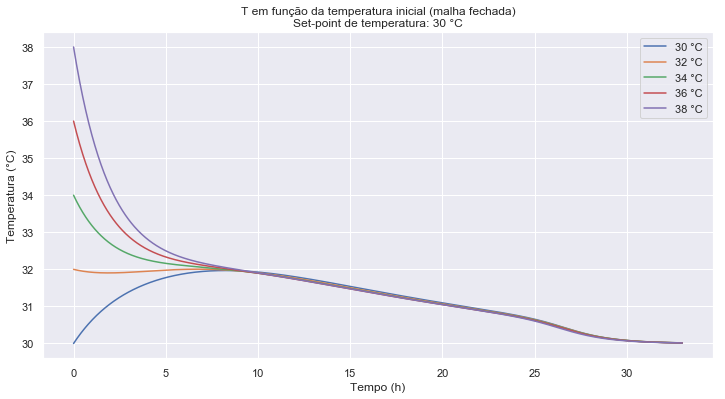

In [18]:
T_30 = Results[0][3][:]
T_32 = Results[1][3][:]
T_34 = Results[2][3][:]
T_36 = Results[3][3][:]
T_38 = Results[4][3][:]

plt.figure(figsize=(12,6))
plt.plot(t,T_30,label="30 °C")
plt.plot(t,T_32,label="32 °C")
plt.plot(t,T_34,label="34 °C")
plt.plot(t,T_36,label="36 °C")
plt.plot(t,T_38,label="38 °C")
plt.xlabel("Tempo (h)")
plt.ylabel("Temperatura (°C)")
plt.title("T em função da temperatura inicial (malha fechada)\nSet-point de temperatura: "+str(Tsp)+" °C")
plt.legend()

### 7. Sensitivity analysis: closed-loop temperature set-point (Tsp)

In [19]:
# Análise de sensibilidade - produtividade x set-point de temperatura com tempo de residência fixo
X0 = 2.75                    # kg/m³
S0 = 150                     # kg/m³
P0 = 0                       # kg/m³
T0 = 30                      # °C
ChuteInicial = [X0,S0,P0,T0]
Tsp_vetor = [30,32,34,36,38] # °C

# 3. declarando o domínio de tempo da simulação: 33 h, divididos em 1000 pontos
n = 1000
t = np.linspace(0,33,n)

# criação do "tensor" que armazenará os resultados das simulações para cada temperatura
Results_sp = np.zeros((len(Tsp_vetor),4,n)) # 5 rodadas de simulação diferentes, cada uma com 4 variáveis-resposta (X,S,P,T) e 1000 pontos (n)

# 4. resolução do sistema de equações diferenciais
for j in range(0,len(Tsp_vetor)):
    
    X_sp = np.empty_like(t)
    S_sp = np.empty_like(t)
    P_sp = np.empty_like(t)
    T_sp = np.empty_like(t)

    X_sp[0] = X0
    S_sp[0] = S0
    P_sp[0] = P0
    T_sp[0] = T0
    
    ChuteInicial = [X0,S0,P0,T0]
    Tsp = Tsp_vetor[j]
    
    for i in range(1,n):
    
        dt = [t[i-1],t[i]]
        Solution = odeint(cinetica_mf,ChuteInicial,dt,args=(Tsp,Frec_hold))

        # Armazenar o resultado da integração no intervalo dt
        X_sp[i] = Solution[1][0]
        S_sp[i] = Solution[1][1]
        P_sp[i] = Solution[1][2]
        T_sp[i] = Solution[1][3]

        # Recalcular o chute inicial para o próximo intervalo dt
        ChuteInicial = [X_sp[i],S_sp[i],P_sp[i],T_sp[i]]
    
    # Armazenar os resultados da batelada de simulação
    Results_sp[j] = np.array([X_sp,S_sp,P_sp,T_sp])


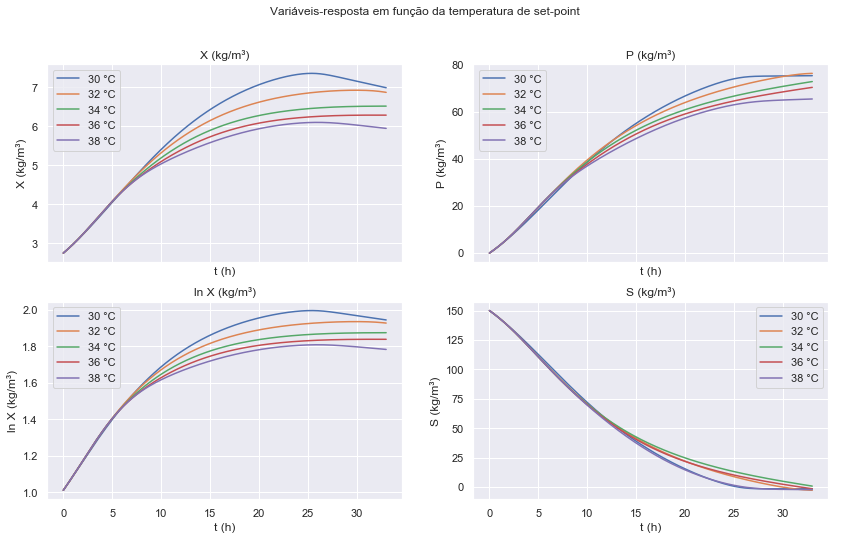

In [20]:
fig, sp = plt.subplots(2,2,sharex=True,figsize=(14,8))
plt.suptitle("Variáveis-resposta em função da temperatura de set-point")

x_0_sp = Results_sp[0][0][:]
x_1_sp = Results_sp[1][0][:]
x_2_sp = Results_sp[2][0][:]
x_3_sp = Results_sp[3][0][:]
x_4_sp = Results_sp[4][0][:]

s_0_sp = Results_sp[0][1][:]
s_1_sp = Results_sp[1][1][:]
s_2_sp = Results_sp[2][1][:]
s_3_sp = Results_sp[3][1][:]
s_4_sp = Results_sp[4][1][:]

p_0_sp = Results_sp[0][2][:]
p_1_sp = Results_sp[1][2][:]
p_2_sp = Results_sp[2][2][:]
p_3_sp = Results_sp[3][2][:]
p_4_sp = Results_sp[4][2][:]

sp[0,0].plot(t,x_0_sp,label="30 °C")
sp[0,0].plot(t,x_1_sp,label="32 °C")
sp[0,0].plot(t,x_2_sp,label="34 °C")
sp[0,0].plot(t,x_3_sp,label="36 °C")
sp[0,0].plot(t,x_4_sp,label="38 °C")
sp[0,0].set_title("X (kg/m³)")
sp[0,0].set_ylabel("X (kg/m³)")
sp[0,0].set_xlabel("t (h)")
sp[0,0].legend()

sp[0,1].plot(t,p_0_sp,label="30 °C")
sp[0,1].plot(t,p_1_sp,label="32 °C")
sp[0,1].plot(t,p_2_sp,label="34 °C")
sp[0,1].plot(t,p_3_sp,label="36 °C")
sp[0,1].plot(t,p_4_sp,label="38 °C")
sp[0,1].set_title("P (kg/m³)")
sp[0,1].set_ylabel("P (kg/m³)")
sp[0,1].set_xlabel("t (h)")
sp[0,1].legend()

sp[1,0].plot(t,np.log(x_0_sp),label="30 °C")
sp[1,0].plot(t,np.log(x_1_sp),label="32 °C")
sp[1,0].plot(t,np.log(x_2_sp),label="34 °C")
sp[1,0].plot(t,np.log(x_3_sp),label="36 °C")
sp[1,0].plot(t,np.log(x_4_sp),label="38 °C")
sp[1,0].set_title("ln X (kg/m³)")
sp[1,0].set_ylabel("ln X (kg/m³)")
sp[1,0].set_xlabel("t (h)")
sp[1,0].legend()

sp[1,1].plot(t,s_0_sp,label="30 °C")
sp[1,1].plot(t,s_1_sp,label="32 °C")
sp[1,1].plot(t,s_2_sp,label="34 °C")
sp[1,1].plot(t,s_3_sp,label="36 °C")
sp[1,1].plot(t,s_4_sp,label="38 °C")
sp[1,1].set_title("S (kg/m³)")
sp[1,1].set_ylabel("S (kg/m³)")
sp[1,1].set_xlabel("t (h)")
sp[1,1].legend()

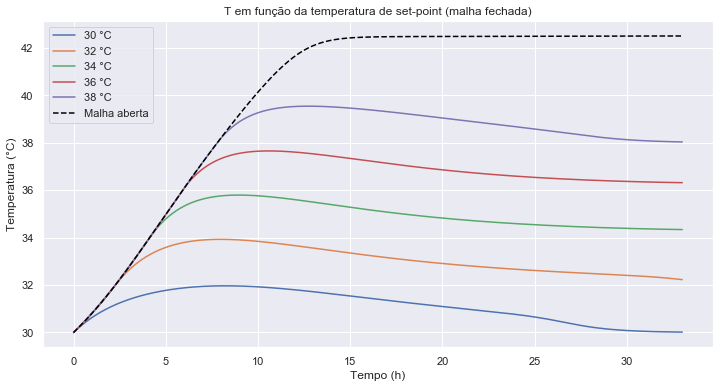

In [21]:
Tsp_0 = Results_sp[0][3][:]
Tsp_1 = Results_sp[1][3][:]
Tsp_2 = Results_sp[2][3][:]
Tsp_3 = Results_sp[3][3][:]
Tsp_4 = Results_sp[4][3][:]

plt.figure(figsize=(12,6))
plt.plot(t,Tsp_0,label="30 °C")
plt.plot(t,Tsp_1,label="32 °C")
plt.plot(t,Tsp_2,label="34 °C")
plt.plot(t,Tsp_3,label="36 °C")
plt.plot(t,Tsp_4,label="38 °C")
plt.plot(t,T_ma,label="Malha aberta",color="black",linestyle='--')
plt.xlabel("Tempo (h)")
plt.ylabel("Temperatura (°C)")
plt.title("T em função da temperatura de set-point (malha fechada)")
plt.legend()

In [22]:
Tsp = Tsp_hold

### 8. Sensitivity analysis: recycle flow rate (Frec)

In [23]:
# Análise de sensibilidade - produtividade x set-point de temperatura com tempo de residência fixo
X0 = 2.75                    # kg/m³
S0 = 150                     # kg/m³
P0 = 0                       # kg/m³
T0 = 30                      # °C
ChuteInicial = [X0,S0,P0,T0]
Tsp = Tsp_hold
Frec_vetor = [3,15,31,46,61,76] # m³/h

# 3. declarando o domínio de tempo da simulação: 33 h, divididos em 1000 pontos
n = 1000
t = np.linspace(0,33,n)

# criação do "tensor" que armazenará os resultados das simulações para cada temperatura
Results_rec = np.zeros((len(Frec_vetor),4,n)) # 5 rodadas de simulação diferentes, cada uma com 4 variáveis-resposta (X,S,P,T) e 1000 pontos (n)

# 4. resolução do sistema de equações diferenciais
for j in range(0,len(Frec_vetor)):
    
    X_rec = np.empty_like(t)
    S_rec = np.empty_like(t)
    P_rec = np.empty_like(t)
    T_rec = np.empty_like(t)

    X_rec[0] = X0
    S_rec[0] = S0
    P_rec[0] = P0
    T_rec[0] = T0
    
    ChuteInicial = [X0,S0,P0,T0]
    Frec = Frec_vetor[j]
    
    for i in range(1,n):
    
        dt = [t[i-1],t[i]]
        Solution = odeint(cinetica_mf,ChuteInicial,dt,args=(Tsp_hold,Frec))

        # Armazenar o resultado da integração no intervalo dt
        X_rec[i] = Solution[1][0]
        S_rec[i] = Solution[1][1]
        P_rec[i] = Solution[1][2]
        T_rec[i] = Solution[1][3]

        # Recalcular o chute inicial para o próximo intervalo dt
        ChuteInicial = [X_rec[i],S_rec[i],P_rec[i],T_rec[i]]
    
    # Armazenar os resultados da batelada de simulação
    Results_rec[j] = np.array([X_rec,S_rec,P_rec,T_rec])


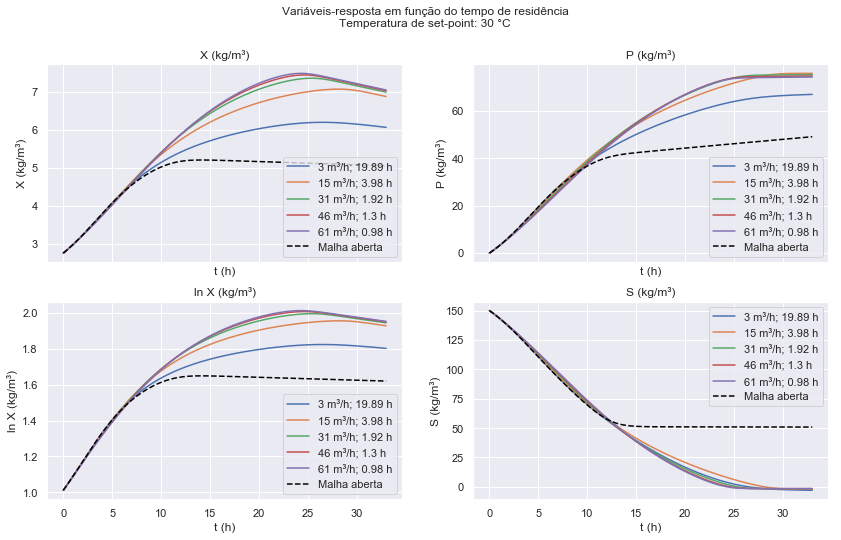

In [24]:
fig, rec = plt.subplots(2,2,sharex=True,figsize=(14,8))
plt.suptitle("Variáveis-resposta em função do tempo de residência\nTemperatura de set-point: "+str(Tsp_hold)+" °C")

x_0_rec = Results_rec[0][0][:]
x_1_rec = Results_rec[1][0][:]
x_2_rec = Results_rec[2][0][:]
x_3_rec = Results_rec[3][0][:]
x_4_rec = Results_rec[4][0][:]
x_5_rec = Results_rec[5][0][:]

s_0_rec = Results_rec[0][1][:]
s_1_rec = Results_rec[1][1][:]
s_2_rec = Results_rec[2][1][:]
s_3_rec = Results_rec[3][1][:]
s_4_rec = Results_rec[4][1][:]
s_5_rec = Results_rec[5][1][:]

p_0_rec = Results_rec[0][2][:]
p_1_rec = Results_rec[1][2][:]
p_2_rec = Results_rec[2][2][:]
p_3_rec = Results_rec[3][2][:]
p_4_rec = Results_rec[4][2][:]
p_5_rec = Results_rec[5][2][:]

rec[0,0].plot(t,x_0_rec,label=(str(Frec_vetor[0])+" m³/h; "+str(round(V/Frec_vetor[0],2))+" h"))
rec[0,0].plot(t,x_1_rec,label=(str(Frec_vetor[1])+" m³/h; "+str(round(V/Frec_vetor[1],2))+" h"))
rec[0,0].plot(t,x_2_rec,label=(str(Frec_vetor[2])+" m³/h; "+str(round(V/Frec_vetor[2],2))+" h"))
rec[0,0].plot(t,x_3_rec,label=(str(Frec_vetor[3])+" m³/h; "+str(round(V/Frec_vetor[3],2))+" h"))
rec[0,0].plot(t,x_4_rec,label=(str(Frec_vetor[4])+" m³/h; "+str(round(V/Frec_vetor[4],2))+" h"))
#rec[0,0].plot(t,x_5_rec,label=(str(Frec_vetor[5])+" m³/h; "+str(round(V/Frec_vetor[5],2))+" h"))
rec[0,0].plot(t,X_ma,label="Malha aberta",color="black",linestyle='--')
rec[0,0].set_title("X (kg/m³)")
rec[0,0].set_ylabel("X (kg/m³)")
rec[0,0].set_xlabel("t (h)")
rec[0,0].legend()

rec[0,1].plot(t,p_0_rec,label=(str(Frec_vetor[0])+" m³/h; "+str(round(V/Frec_vetor[0],2))+" h"))
rec[0,1].plot(t,p_1_rec,label=(str(Frec_vetor[1])+" m³/h; "+str(round(V/Frec_vetor[1],2))+" h"))
rec[0,1].plot(t,p_2_rec,label=(str(Frec_vetor[2])+" m³/h; "+str(round(V/Frec_vetor[2],2))+" h"))
rec[0,1].plot(t,p_3_rec,label=(str(Frec_vetor[3])+" m³/h; "+str(round(V/Frec_vetor[3],2))+" h"))
rec[0,1].plot(t,p_4_rec,label=(str(Frec_vetor[4])+" m³/h; "+str(round(V/Frec_vetor[4],2))+" h"))
#rec[0,1].plot(t,p_5_rec,label=(str(Frec_vetor[5])+" m³/h; "+str(round(V/Frec_vetor[5],2))+" h"))
rec[0,1].plot(t,P_ma,label="Malha aberta",color="black",linestyle='--')
rec[0,1].set_title("P (kg/m³)")
rec[0,1].set_ylabel("P (kg/m³)")
rec[0,1].set_xlabel("t (h)")
rec[0,1].legend()

rec[1,0].plot(t,np.log(x_0_rec),label=(str(Frec_vetor[0])+" m³/h; "+str(round(V/Frec_vetor[0],2))+" h"))
rec[1,0].plot(t,np.log(x_1_rec),label=(str(Frec_vetor[1])+" m³/h; "+str(round(V/Frec_vetor[1],2))+" h"))
rec[1,0].plot(t,np.log(x_2_rec),label=(str(Frec_vetor[2])+" m³/h; "+str(round(V/Frec_vetor[2],2))+" h"))
rec[1,0].plot(t,np.log(x_3_rec),label=(str(Frec_vetor[3])+" m³/h; "+str(round(V/Frec_vetor[3],2))+" h"))
rec[1,0].plot(t,np.log(x_4_rec),label=(str(Frec_vetor[4])+" m³/h; "+str(round(V/Frec_vetor[4],2))+" h"))
#rec[1,0].plot(t,np.log(x_5_rec),label=(str(Frec_vetor[5])+" m³/h; "+str(round(V/Frec_vetor[5],2))+" h"))
rec[1,0].plot(t,np.log(X_ma),label="Malha aberta",linestyle='--',color="black")
rec[1,0].set_title("ln X (kg/m³)")
rec[1,0].set_ylabel("ln X (kg/m³)")
rec[1,0].set_xlabel("t (h)")
rec[1,0].legend(loc="lower right")

rec[1,1].plot(t,s_0_rec,label=(str(Frec_vetor[0])+" m³/h; "+str(round(V/Frec_vetor[0],2))+" h"))
rec[1,1].plot(t,s_1_rec,label=(str(Frec_vetor[1])+" m³/h; "+str(round(V/Frec_vetor[1],2))+" h"))
rec[1,1].plot(t,s_2_rec,label=(str(Frec_vetor[2])+" m³/h; "+str(round(V/Frec_vetor[2],2))+" h"))
rec[1,1].plot(t,s_3_rec,label=(str(Frec_vetor[3])+" m³/h; "+str(round(V/Frec_vetor[3],2))+" h"))
rec[1,1].plot(t,s_4_rec,label=(str(Frec_vetor[4])+" m³/h; "+str(round(V/Frec_vetor[4],2))+" h"))
#rec[1,1].plot(t,s_5_rec,label=(str(Frec_vetor[5])+" m³/h; "+str(round(V/Frec_vetor[5],2))+" h"))
rec[1,1].plot(t,S_ma,label="Malha aberta",color="black",linestyle='--')
rec[1,1].set_title("S (kg/m³)")
rec[1,1].set_ylabel("S (kg/m³)")
rec[1,1].set_xlabel("t (h)")
rec[1,1].legend()

Tempo de residência: 
$$
\tau = \frac{V_{R}}{F}
$$

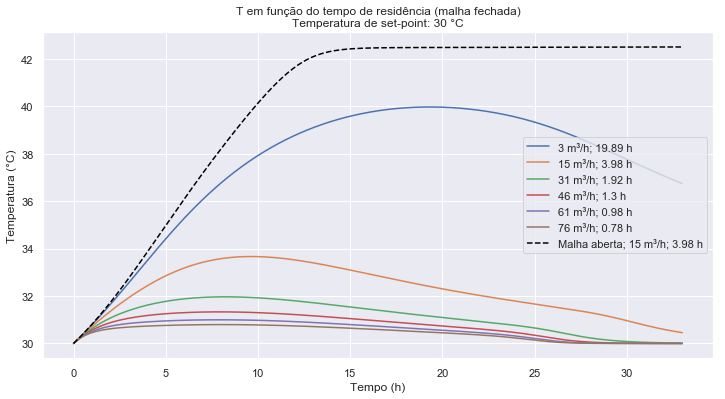

In [25]:
Trec_0 = Results_rec[0][3][:]
Trec_1 = Results_rec[1][3][:]
Trec_2 = Results_rec[2][3][:]
Trec_3 = Results_rec[3][3][:]
Trec_4 = Results_rec[4][3][:]
Trec_5 = Results_rec[5][3][:]

plt.figure(figsize=(12,6))
plt.plot(t,Trec_0,label=(str(Frec_vetor[0])+" m³/h; "+str(round(V/Frec_vetor[0],2))+" h"))
plt.plot(t,Trec_1,label=(str(Frec_vetor[1])+" m³/h; "+str(round(V/Frec_vetor[1],2))+" h"))
plt.plot(t,Trec_2,label=(str(Frec_vetor[2])+" m³/h; "+str(round(V/Frec_vetor[2],2))+" h"))
plt.plot(t,Trec_3,label=(str(Frec_vetor[3])+" m³/h; "+str(round(V/Frec_vetor[3],2))+" h"))
plt.plot(t,Trec_4,label=(str(Frec_vetor[4])+" m³/h; "+str(round(V/Frec_vetor[4],2))+" h"))
plt.plot(t,Trec_5,label=(str(Frec_vetor[5])+" m³/h; "+str(round(V/Frec_vetor[5],2))+" h"))
plt.plot(t,T_ma,label=("Malha aberta; "+str(Frec_vetor[1])+" m³/h; "+str(round(V/Frec_vetor[1],2))+" h"),color="black",linestyle='--')
plt.xlabel("Tempo (h)")
plt.ylabel("Temperatura (°C)")
plt.title("T em função do tempo de residência (malha fechada)\nTemperatura de set-point: "+str(Tsp_hold)+" °C")
plt.legend(loc="right")

Tempo de residência: $\tau = \frac{V_{R}}{F}$

### 9. Productivity calculations

In [26]:
vetor_s_sp = np.array([s_0_sp,s_1_sp,s_2_sp,s_3_sp,s_4_sp])
vetor_s_rec = np.array([s_0_rec,s_1_rec,s_2_rec,s_3_rec,s_4_rec,s_5_rec])

vetor_p_sp = np.array([p_0_sp,p_1_sp,p_2_sp,p_3_sp,p_4_sp])
vetor_p_rec = np.array([p_0_rec,p_1_rec,p_2_rec,p_3_rec,p_4_rec,p_5_rec])

index_sp = np.zeros(len(vetor_s_sp))
t_sp = np.zeros(len(vetor_s_sp))
p_sp = np.zeros(len(vetor_s_sp))
prod_sp = np.zeros(len(vetor_s_sp))

index_rec = np.zeros(len(vetor_s_rec))
t_rec = np.zeros(len(vetor_s_rec))
p_rec = np.zeros(len(vetor_s_rec))
prod_rec = np.zeros(len(vetor_s_rec))

for i in range(0,len(vetor_s_sp)):
    index_sp[i] = int(np.max(np.where((vetor_s_sp[i] <= 1) & (vetor_s_sp[i] >= 0))))
    t_sp[i] = t[int(index_sp[i])]
    p_sp[i] = vetor_p_sp[i][int(index_sp[i])]
    prod_sp[i] = p_sp[i]/t_sp[i]               # produtividade em kg/m³.h de etanol
    
for i in range(0,len(vetor_s_rec)):
    index_rec[i] = int(np.max(np.where((vetor_s_rec[i] <= 1) & (vetor_s_rec[i] >= 0))))
    t_rec[i] = t[int(index_rec[i])]
    p_rec[i] = vetor_p_rec[i][int(index_rec[i])]
    prod_rec[i] = p_rec[i]/t_rec[i]            # produtividade em kg/m³.h de etanol

Text(0.5, 0, 'Vazão de reciclo (m³/h)')

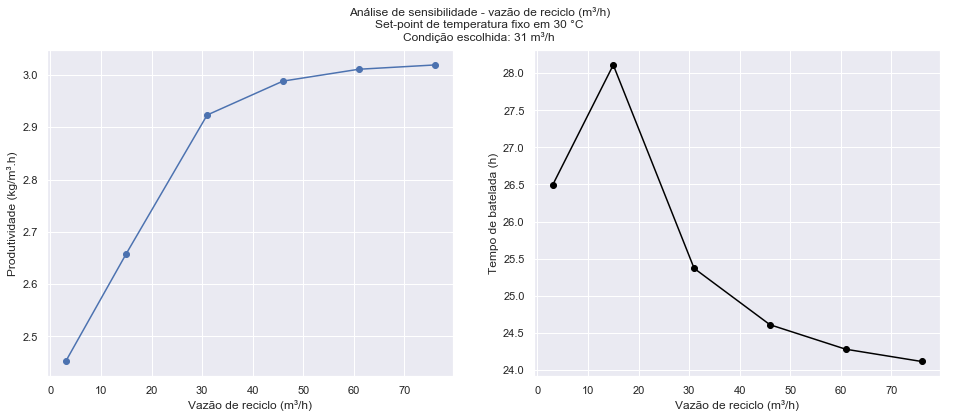

In [27]:
fig, eixos = plt.subplots(1,2,figsize=(16,6))
plt.suptitle("Análise de sensibilidade - vazão de reciclo (m³/h)\nSet-point de temperatura fixo em "+str(Tsp_hold)+" °C\nCondição escolhida: 31 m³/h")

eixos[0].plot(Frec_vetor,prod_rec,label="Produtividade (kg/m³.h)",marker='o')
eixos[0].set_ylabel("Produtividade (kg/m³.h)")
eixos[0].set_xlabel("Vazão de reciclo (m³/h)")

eixos[1].plot(Frec_vetor,t_rec,label="Tempo de batelada (h)",color="black",marker='o')
eixos[1].set_ylabel("Tempo de batelada (h)")
eixos[1].set_xlabel("Vazão de reciclo (m³/h)")

Text(0.5, 0, 'Temperatura de set-point (°C)')

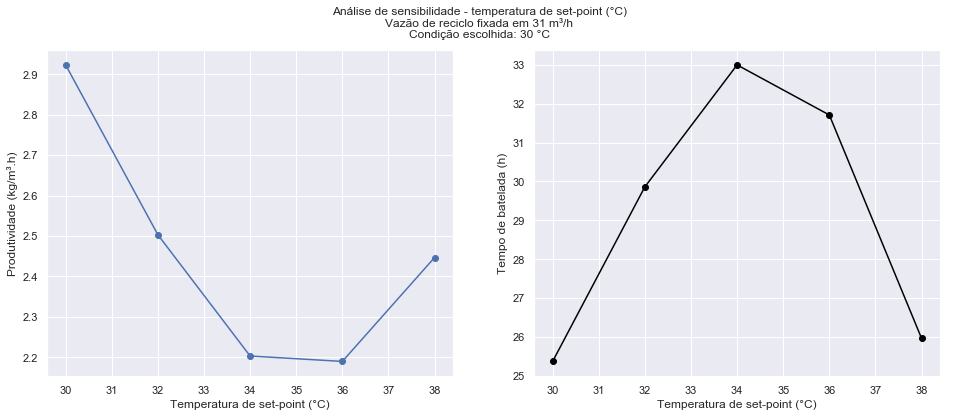

In [28]:
fig, eixos2 = plt.subplots(1,2,figsize=(16,6))
plt.suptitle("Análise de sensibilidade - temperatura de set-point (°C)\nVazão de reciclo fixada em "+str(Frec_hold)+" m³/h\nCondição escolhida: "+str(Tsp_hold)+" °C")

eixos2[0].plot(Tsp_vetor,prod_sp,label="Produtividade (kg/m³.h)",marker='o')
eixos2[0].set_ylabel("Produtividade (kg/m³.h)")
eixos2[0].set_xlabel("Temperatura de set-point (°C)")

eixos2[1].plot(Tsp_vetor,t_sp,label="Tempo de batelada (h)",color="black",marker='o')
eixos2[1].set_ylabel("Tempo de batelada (h)")
eixos2[1].set_xlabel("Temperatura de set-point (°C)")